# CR model: Linear imputation is overly simple

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import LSTM
from scipy.stats import norm
from scipy.integrate import solve_ivp, quad, dblquad
from scipy.interpolate import interp1d

from bayesflow.networks import InvertibleNetwork 
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.models import GenerativeModel

## Simulator settings

In [2]:
def prior(batch_size):
    """
    Samples from the prior 'batch_size' times.
    ----------
    Output:
    theta : np.ndarray of shape (batch_size, theta_dim) 
    """    
    # Prior range for log-parameters: k_1, k_2 ~ N(-0.75, 0.25²) iid.
    p_samples = np.random.normal(-0.75, 0.25, size=(batch_size, 2))
    return p_samples.astype(np.float32)


# ODE model for conversion reaction  
def conversion_reaction(t, x, theta):
    theta = 10**theta
    return np.array([-theta[0]*x[0]+theta[1]*x[1], theta[0]*x[0]-theta[1]*x[1]]) 

x0 = [1,0]   # initial condition       
sigma = 0.015   # noise standard deviation
n_obs = 3
time_points = np.linspace(0, 10, n_obs)
missing_max = 2

We load the cINN trained on complete data sets and apply it to imputed data.

In [3]:
bf_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [64, 64, 64],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': 2
}

In [4]:
summary_net = None
inference_net = InvertibleNetwork(bf_meta)
amortizer = SingleModelAmortizer(inference_net, summary_net)
ParameterEstimationTrainer(network=amortizer, checkpoint_path='./CR3_4ACB_[64,64,64]_ckpts', skip_checks=True)

TRAINER INITIALIZATION: No generative model provided. Only offline learning mode is available!
Networks loaded from ./CR3_4ACB_[64,64,64]_ckpts\ckpt-300


## Computational faithfulness

In [5]:
# Test data
param_prior = np.array([[-0.7747589, -0.7236521]])
result = [np.array([-3.23788010e-04,  4.09819164e-01,  4.91645435e-01]), np.array([0, 2]), np.array([ 0., 10.])]

# Impute the missing value via linear interpolation
present_indices = result[1]
missing_indices = np.setdiff1d(range(n_obs), present_indices)
f = interp1d(time_points[present_indices], result[0][present_indices])
data_imputed = np.copy(result[0])
data_imputed[missing_indices] = f(time_points[missing_indices])
x_data = np.array([data_imputed]).astype(np.float32)   

# Sample from BayesFlow
n_post_samples = 2000   
param_samples = amortizer.sample(x_data, n_post_samples)   

In [6]:
def plot_marginal(ax, result, param_samples):  
    
    def prior_eval(x,y):   
        # Evaluates prior probability p(theta) according to k_1, k_2 ~ N(-0.75, 0.25²) iid.
        return norm.pdf(x,-0.75,0.25) * norm.pdf(y,-0.75,0.25)
    
    def likelihood_avai(x,y):   
        # Calculates likelihood of available data
        x = 10**x
        y = 10**y
        s = x + y
        b = x/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(result[2])
        residual = (result[0][result[1]] - sol)/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return np.exp(-nllh)

    def unnormalized_posterior_avai(x,y):   
        # Evaluates the unnormalized posterior probability according to Bayes' formula
        return likelihood_avai(x,y) * prior_eval(x,y)
    
    def likelihood_orig(x,y):   
        # Calculates likelihood of full original data
        x = 10**x
        y = 10**y
        s = x + y
        b = x/s
        state_2 = lambda t: b - b * np.exp(-s*t)
        sol = state_2(time_points)
        residual = (result[0] - sol)/sigma
        nllh = np.sum(np.log(2*np.pi*sigma**2)+residual**2)/2
        return np.exp(-nllh)

    def unnormalized_posterior_orig(x,y):   
        # Evaluates the unnormalized posterior probability according to Bayes' formula
        return likelihood_orig(x,y) * prior_eval(x,y)

    # scaling factor
    scaling_factor_avai = dblquad(unnormalized_posterior_avai, -2.5, 1., lambda y: -2.5, lambda y: 1.)
    scaling_factor_orig = dblquad(unnormalized_posterior_orig, -2.5, 1., lambda y: -2.5, lambda y: 1.)

    # normalized posterior
    posterior_xy_avai = lambda x,y: unnormalized_posterior_avai(x,y)/scaling_factor_avai[0]
    posterior_xy_orig = lambda x,y: unnormalized_posterior_orig(x,y)/scaling_factor_orig[0]    
    
    # Compute marginal densities
    grid = 301
    A = np.linspace(-1.3, -0.2, grid)
    B = np.linspace(-2.4, 0., grid)
    bounds = np.array([-2.5, 1., -2.5, 1.])
    
    ax[0].hist(param_samples[:, 0], bins='auto', density=1, color='orange', label='BayesFlow \n on imputed data')
    marginal_x_avai = np.zeros(grid)
    marginal_x_orig = np.zeros(grid)
    for i in range(grid):
        x = A[i]
        integrand_y_avai = lambda y: posterior_xy_avai(x, y)
        marginal_x_avai[i] = quad(integrand_y_avai, bounds[2], bounds[3])[0]
        integrand_y_orig = lambda y: posterior_xy_orig(x, y)
        marginal_x_orig[i] = quad(integrand_y_orig, bounds[2], bounds[3])[0]
    ax[0].plot(A, marginal_x_avai, label='Posterior cond. \n on available data')
    ax[0].plot(A, marginal_x_orig, color='red', label='Posterior cond. \n on complete data')
    ax[0].set_ylabel('Marginal density')
    ax[0].set_xlabel('Parameter $k_1$')
    handles, labels = ax[0].get_legend_handles_labels()
    order = [1,2,0]
    ax[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order])
    ax[0].set_title('                                                      Posterior distribution', loc='center', pad=6) 

    ax[1].hist(param_samples[:, 1], bins='auto', density=1, color='orange')
    marginal_y_avai = np.zeros(grid)
    marginal_y_orig = np.zeros(grid)
    for j in range(grid):
        y = B[j]
        integrand_x_avai = lambda x: posterior_xy_avai(x, y)
        marginal_y_avai[j] = quad(integrand_x_avai, bounds[0], bounds[1])[0]
        integrand_x_orig = lambda x: posterior_xy_orig(x, y)
        marginal_y_orig[j] = quad(integrand_x_orig, bounds[0], bounds[1])[0]    
    ax[1].plot(B, marginal_y_avai)
    ax[1].plot(B, marginal_y_orig, color='red')
    ax[1].set_xlim(-2.515, 0.12)    
    ax[1].set_xlabel('Parameter $k_2$')

In [8]:
def predictive_check(ax, param_prior, result, param_samples, n_sim=101):

    for k in range(n_sim):
        rhs = lambda t,x: conversion_reaction(t, x, param_samples[k])
        sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)   
        if k == 0:
            ax.plot(np.array([0]), np.array([0]), color='grey', label='Simulation', linewidth=0.9)
        else: 
            ax.plot(sol.t, sol.y[1], color='grey', linewidth=0.5, alpha=0.3)
                
    rhs = lambda t,x: conversion_reaction(t, x, param_prior[0])
    sol = solve_ivp(rhs, t_span = (0,10), y0 = x0, atol = 1e-9, rtol = 1e-6)
    ax.plot(sol.t, sol.y[1], color='black', label='True trajectory')    
    
    present_indices = result[1]
    missing_indices = np.setdiff1d(range(n_obs), present_indices)
    ax.plot(time_points[present_indices], result[0][present_indices], 'o', label='Available data')
    ax.plot(time_points[missing_indices], result[0][missing_indices], 'o', color='red', label='Missing data')
    ax.plot(time_points[missing_indices], data_imputed[missing_indices], 'o', color='tab:orange', label='Imputed value')
    
    ax.set_xlabel('Time $t$')
    ax.set_ylabel("Measurement $y$")
    ax.set_title('Posterior predictive check', loc='center', pad=6)
    handles, labels = ax.get_legend_handles_labels()
    order = [1,2,3,4,0]
    ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

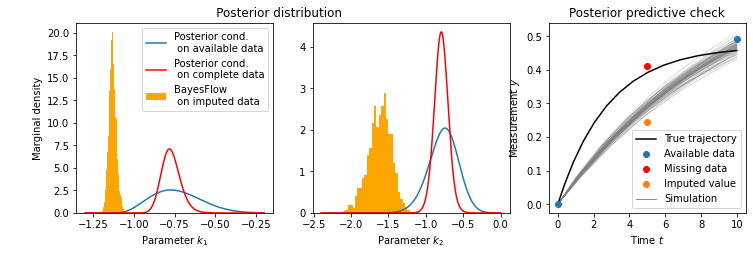

In [9]:
fig, ax = plt.subplots(1, 3, figsize=((12, 3.5)))

plot_marginal(ax[0:2], result, param_samples)
predictive_check(ax[2], param_prior, result, param_samples)
fig.savefig("figures/linear_interpolation.png", dpi=300, bbox_inches='tight') 
fig.savefig("figures/linear_interpolation.pdf", bbox_inches='tight')